In [1]:
# Google Colabと自分のパソコンの両方で使えるようにするための工夫

using Pkg

"""すでにPkg.add済みのパッケージのリスト"""
_packages_added = [sort!(readdir(Sys.STDLIB));
    sort!([info.name for (uuid, info) in Pkg.dependencies() if info.is_direct_dep])]

"""_packages_added内にないパッケージをPkg.addする"""
add_pkg_if_not_added_yet(pkg) = if isnothing(Base.find_package(pkg))
    println(stderr, "# $(pkg).jl is not added yet, so let's add it.")
    Pkg.add(pkg)
end

"""expr::Exprからusing内の`.`を含まないモジュール名を抽出"""
function find_using_pkgs(expr::Expr)
    pkgs = String[]
    function traverse(expr::Expr)
        if expr.head == :using
            for arg in expr.args
                if arg.head == :. && length(arg.args) == 1
                    push!(pkgs, string(arg.args[1]))
                elseif arg.head == :(:) && length(arg.args[1].args) == 1
                    push!(pkgs, string(arg.args[1].args[1]))
                end
            end
        else
            for arg in expr.args arg isa Expr && traverse(arg) end
        end
    end
    traverse(expr)
    pkgs
end

"""必要そうなPkg.addを追加するマクロ"""
macro autoadd(expr)
    pkgs = find_using_pkgs(expr)
    :(add_pkg_if_not_added_yet.($(pkgs)); $expr)
end

@autoadd

In [2]:
@autoadd begin
using Distributions
#using QuadGK
using Roots
#using SpecialFunctions
#using StaticArrays
#using StatsBase
#using StatsFuns
using StatsPlots
default(fmt = :png, size = (600, 400),
    titlefontsize = 10, plot_titlefontsize = 12)
#using SymPy
end

In [3]:
safemul(x, y) = x == 0 ? x : isinf(x) ? oftype(x, Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y
x ⪅ y = x < y || x ≈ y
distname(dist::Distribution) = replace(string(dist), r"{.*}" => "")

rawtick(tick=Any[0.5, 0.7, 1, 1.5, 2, 3, 5, 7, 10, 20]) = (tick, string.(tick))

xs_default = Any[
    0.001, 0.0015, 0.002, 0.003, 0.005, 0.007,
    0.01, 0.015, 0.02, 0.03, 0.05, 0.07,
    0.1, 0.15, 0.2, 0.3, 0.5, 0.7,
    1, 1.5, 2, 3, 5, 7,
    10, 15, 20, 30, 50, 70,
    100, 150, 200, 300, 500, 700
]

logtick(xmin, xmax; xs=xs_default) = rawtick(xs[xmin .≤ xs .≤ xmax])
logtick(0.5, 10)

(Any[0.5, 0.7, 1, 1.5, 2, 3, 5, 7, 10], ["0.5", "0.7", "1", "1.5", "2", "3", "5", "7", "10"])

In [4]:
function delta(a, b, c, d; ω=1)
    A, B, C = 1-ω, a+d+ω*(b+c), a*d-ω*b*c
    isinf(ω) ? oftype(ω, -min(b, c)) : safediv(2C, B + √(B^2 - 4A*C))
end

# correction = 0.5 は連続性補正を与える.
function _chisqstat_or(a, b, c, d, δ; correction=0.0)
    ã, b̃, c̃, d̃ = a-δ, b+δ, c+δ, d-δ
    safemul(max(0, abs(δ)-correction)^2, 1/ã + 1/b̃ + 1/c̃ + 1/d̃)
end

function chisqstat_or(a, b, c, d; ω=1, correction=0.0)
    δ = delta(a, b, c, d; ω)
    _chisqstat_or(a, b, c, d, δ; correction)
end

function pvalue_or_pearson_chisq(a, b, c, d; ω=1, correction=0.0)
    χ² = chisqstat_or(a, b, c, d; ω, correction)
    ccdf(Chisq(1), χ²)
end

function confint_or_pearson_chisq(a, b, c, d; α=0.05, correction=0.0)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_pearson_chisq(a, b, c, d; ω=exp(logω), correction)) - logit(α)
    ps = if a == 0 || d == 0
        [0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ORhat = oddsratiohat(a, b, c, d)
        ω_L, ω_U = ORhat/2, 2ORhat
        [exp(find_zero(f, log(ω_L))), exp(find_zero(f, log(ω_U)))]
    end
end

confint_or_pearson_chisq (generic function with 1 method)

In [5]:
_riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)

function Delta(a, b, c, d; ρ=1.0)
    m, n = a+b, c+d
    A, B, C = ρ-1, n-a+ρ*(m-c), a*n-ρ*m*c
    Δ = isinf(ρ) ? oftype(ρ, -c) : ρ==0 ? oftype(ρ, a) : safediv(2C, B + √(B^2 - 4A*C))
end

function _chisqstat_rr(a, b, c, d, Δ)
    m, n = a+b, c+d
    safemul(Δ^2, safediv(b, m*(a-Δ)) + safediv(d, n*(c+Δ)))
end

function chisqstat_rr(a, b, c, d; ρ=1.0)
    Δ = Delta(a, b, c, d; ρ)
    _chisqstat_rr(a, b, c, d, Δ)
end

function pvalue_rr_pearson_chisq(a, b, c, d; ρ=1.0)
    χ² = chisqstat_rr(a, b, c, d; ρ)
    ccdf(Chisq(1), χ²)
end

function confint_rr_pearson_chisq(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0.0, Inf]
    f(logρ) = logit(pvalue_rr_pearson_chisq(a, b, c, d; ρ=exp(logρ))) - logit(α)
    L = if f(-Inf) > 0
        -Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat - 1
        find_zero(f, x0)
    end
    U = if f(Inf) > 0
        Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat + 1
        find_zero(f, x0)
    end
    [exp(L), exp(U)]
end


confint_rr_pearson_chisq (generic function with 1 method)

(a, b, c, d) = round.(Int, 56 .* (0.21, 0.38, 0.3, 0.11)) = (12, 21, 17, 6)
pvalue_or_pearson_chisq(a, b, c, d; ω = 1) = 0.005665446727750443
pvalue_or_pearson_chisq(a, b, c, d; ω = 1, correction = 0.5) = 0.012604929468887038
1 / ((a / b) / (c / d)) = 4.958333333333334


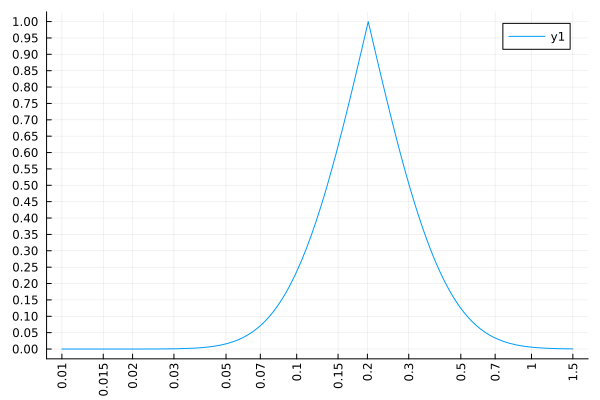

In [6]:
@show a, b, c, d = round.(Int, 56 .* (0.21, 0.38, 0.30, 0.11))
@show pvalue_or_pearson_chisq(a, b, c, d; ω=1)
@show pvalue_or_pearson_chisq(a, b, c, d; ω=1, correction=0.5)
@show 1 / ((a/b) / (c/d))

P = plot(ω -> pvalue_or_pearson_chisq(a, b, c, d; ω), 0.01, 1.5)
plot!(xtick=logtick(0.01, 1.5), ytick=0:0.05:1)
plot!(xscale=:log10, xrotation=90)

(a, b, c, d) = 100 .* (0.2, 0.382, 0.309, 0.109) = (20.0, 38.2, 30.9, 10.9)
pvalue_or_pearson_chisq(a, b, c, d; ω = 1) = 9.501205314233366e-5
pvalue_or_pearson_chisq(a, b, c, d; ω = 1, correction = 0.5) = 0.0002154203060539618
1 / ((a / b) / (c / d)) = 5.414587155963303


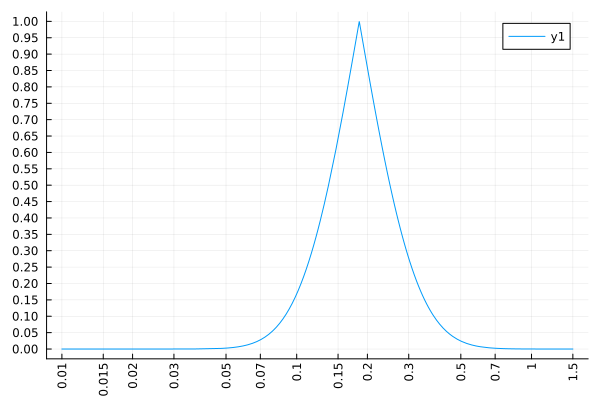

In [7]:
@show a, b, c, d = 100 .* (0.20, 0.382, 0.309, 0.109)
@show pvalue_or_pearson_chisq(a, b, c, d; ω=1)
@show pvalue_or_pearson_chisq(a, b, c, d; ω=1, correction=0.5)
@show 1 / ((a/b) / (c/d))

P = plot(ω -> pvalue_or_pearson_chisq(a, b, c, d; ω), 0.01, 1.5)
plot!(xtick=logtick(0.01, 1.5), ytick=0:0.05:1)
plot!(xscale=:log10, xrotation=90)